# Advantage Actor Critic

## Hyperparameters

In [1]:
from utils.hyperparameters import Config

config = Config()

# meta info
config.algo = 'a2c'
config.env_id = 'BreakoutNoFrameskip-v4'
config.seed = None
config.inference = False
config.print_threshold = 100
config.save_threshold = 1000
config.render = False

# preprocessing
config.stack_frames = 4
config.adaptive_repeat = [4]
config.s_norm = 255.0
config.sticky_actions = 0.0

# Learning Control Variables
config.max_tsteps  = int(1e7)
config.learn_start = 0
config.num_envs    = 16
config.update_freq = 5
config.lr          = 7e-4
config.use_lr_schedule = True
config.grad_norm_max = 0.5
config.gamma = 0.99

# RMSProp params
config.rms_alpha = 0.99
config.rms_eps = 1e-5

#Recurrent control
config.policy_gradient_recurrent_policy = False
config.gru_size = 512

# A2C Controls
config.entropy_loss_weight=0.01
config.value_loss_weight=0.5

## Rollout Storage

In [2]:
import torch

def _flatten_helper(T, N, _tensor):
    return _tensor.view(T * N, *_tensor.size()[2:])

class RolloutStorage(object):
    def __init__(self, num_steps, num_processes, obs_shape, action_space, state_size, device, USE_GAE=True, gae_tau=0.95):
        self.observations = torch.zeros(num_steps + 1, num_processes, *obs_shape).to(device)
        self.states = torch.zeros(num_steps + 1, num_processes, state_size).to(device)
        self.rewards = torch.zeros(num_steps, num_processes, 1).to(device)
        self.value_preds = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.returns = torch.zeros(num_steps + 1, num_processes, 1).to(device)
        self.action_log_probs = torch.zeros(num_steps, num_processes, 1).to(device)
        self.actions = torch.zeros(num_steps, num_processes, 1).to(device, torch.long)
        self.masks = torch.ones(num_steps + 1, num_processes, 1).to(device)

        self.num_steps = num_steps
        self.step = 0
        self.gae = USE_GAE
        self.gae_tau = gae_tau

    def insert(self, current_obs, state, action, action_log_prob, value_pred, reward, mask):
        self.observations[self.step + 1].copy_(current_obs)
        self.states[self.step + 1].copy_(state)
        self.actions[self.step].copy_(action)
        self.action_log_probs[self.step].copy_(action_log_prob)
        self.value_preds[self.step].copy_(value_pred)
        self.rewards[self.step].copy_(reward)
        self.masks[self.step + 1].copy_(mask)

        self.step = (self.step + 1) % self.num_steps

    def after_update(self):
        self.observations[0].copy_(self.observations[-1])
        self.states[0].copy_(self.states[-1])
        self.masks[0].copy_(self.masks[-1])

    def compute_returns(self, next_value, gamma):
        self.returns[-1] = next_value
        for step in reversed(range(self.rewards.size(0))):
            self.returns[step] = self.returns[step + 1] * \
                gamma * self.masks[step + 1] + self.rewards[step]

## Network

In [3]:
import torch.nn as nn
import torch.nn.functional as F
from networks.layers import NoisyLinear

class ActorCritic(nn.Module):
    def __init__(self, input_shape, num_actions, conv_out=32, use_gru=False, gru_size=256, noisy_nets=False, sigma_init=0.5):
        super(ActorCritic, self).__init__()
        self.conv_out = conv_out
        self.use_gru = use_gru
        self.gru_size = gru_size
        self.noisy_nets = noisy_nets

        init_ = lambda m: self.layer_init(m, nn.init.orthogonal_,
                    lambda x: nn.init.constant_(x, 0),
                    nn.init.calculate_gain('relu'))

        self.conv1 = init_(nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4))
        self.conv2 = init_(nn.Conv2d(32, 64, kernel_size=4, stride=2))
        self.conv3 = init_(nn.Conv2d(64, self.conv_out, kernel_size=3, stride=1))

        init_ = lambda m: self.layer_init(m, nn.init.orthogonal_,
                        lambda x: nn.init.constant_(x, 0),
                        nn.init.calculate_gain('relu'),
                        noisy_layer=self.noisy_nets)
        if use_gru:
            self.fc1 = init_(nn.Linear(self.feature_size(input_shape), 512)) if not self.noisy_nets else init_(NoisyLinear(self.feature_size(input_shape), 512, sigma_init))
            self.gru = nn.GRU(512, self.gru_size)
            for name, param in self.gru.named_parameters():
                if 'bias' in name:
                    nn.init.constant_(param, 0)
                elif 'weight' in name:
                    nn.init.orthogonal_(param)
        else:
            self.fc1 = init_(nn.Linear(self.feature_size(input_shape), self.gru_size)) if not self.noisy_nets else init_(NoisyLinear(self.feature_size(input_shape), self.gru_size, sigma_init))

        init_ = lambda m: self.layer_init(m, nn.init.orthogonal_,
                    lambda x: nn.init.constant_(x, 0), gain=1,
                    noisy_layer=self.noisy_nets)

        self.critic_linear = init_(nn.Linear(self.gru_size, 1)) if not self.noisy_nets else init_(NoisyLinear(self.gru_size, 1, sigma_init))

        init_ = lambda m: self.layer_init(m, nn.init.orthogonal_,
                    lambda x: nn.init.constant_(x, 0), gain=0.01,
                    noisy_layer=self.noisy_nets)

        self.actor_linear = init_(nn.Linear(self.gru_size, num_actions)) if not self.noisy_nets else init_(NoisyLinear(self.gru_size, num_actions, sigma_init))
        
        self.train()
        if self.noisy_nets:
            self.sample_noise()

    def forward(self, inputs, states, masks):
        x = F.relu(self.conv1(inputs))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))


        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        if self.use_gru:
            if inputs.size(0) == states.size(0):
                x, states = self.gru(x.unsqueeze(0), (states * masks).unsqueeze(0))
                x = x.squeeze(0)
                states = states.squeeze(0)
            else:
                # x is a (T, N, -1) tensor that has been flatten to (T * N, -1)
                N = states.size(0)
                T = int(x.size(0) / N)

                # unflatten
                x = x.view(T, N, x.size(1))

                # Same deal with masks
                masks = masks.view(T, N)

                # Let's figure out which steps in the sequence have a zero for any agent
                # We will always assume t=0 has a zero in it as that makes the logic cleaner
                has_zeros = ((masks[1:] == 0.0) \
                                .any(dim=-1)
                                .nonzero()
                                .squeeze()
                                .cpu())

                # +1 to correct the masks[1:]
                if has_zeros.dim() == 0:
                    # Deal with scalar
                    has_zeros = [has_zeros.item() + 1]
                else:
                    has_zeros = (has_zeros + 1).numpy().tolist()

                # add t=0 and t=T to the list
                has_zeros = [0] + has_zeros + [T]

                states = states.unsqueeze(0)
                outputs = []
                for i in range(len(has_zeros) - 1):
                    # We can now process steps that don't have any zeros in masks together!
                    # This is much faster
                    start_idx = has_zeros[i]
                    end_idx = has_zeros[i + 1]

                    rnn_scores, states = self.gru(x[start_idx:end_idx], states * \
                        masks[start_idx].view(1, -1, 1))

                    outputs.append(rnn_scores)

                # assert len(outputs) == T
                # x is a (T, N, -1) tensor
                x = torch.cat(outputs, dim=0)
                
                # flatten
                x = x.view(T * N, -1)
                states = states.squeeze(0)

        value = self.critic_linear(x)
        logits = self.actor_linear(x)

        return logits, value, states

    def layer_init(self, module, weight_init, bias_init, gain=1, noisy_layer=False):
        if not noisy_layer:
            weight_init(module.weight.data, gain=gain)
            bias_init(module.bias.data)
        else:
            weight_init(module.weight_mu.data, gain=gain)
            bias_init(module.bias_mu.data)
        return module

    def sample_noise(self):
        if self.noisy_nets:
            self.critic_linear.sample_noise()
            self.actor_linear.sample_noise()
            self.fc1.sample_noise()

    def feature_size(self, input_shape):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *input_shape)))).view(1, -1).size(1)
    
    @property
    def state_size(self):
        if self.use_gru:
            return self.gru_size
        else:
            return 1

## Agent

In [4]:
from agents.BaseAgent import BaseAgent
import torch.optim as optim
from collections import deque
import numpy as np

class Agent(BaseAgent):
    def __init__(self, env=None, config=None, log_dir='/tmp/gym', tb_writer=None):
        super(Agent, self).__init__(env=env, config=config, log_dir=log_dir, tb_writer=tb_writer)
        self.config = config
        self.num_feats = env.observation_space.shape
        self.num_actions = env.action_space.n * len(config.adaptive_repeat)
        self.envs = env

        self.declare_networks()

        self.optimizer = optim.RMSprop(self.model.parameters(), lr=self.config.lr, alpha=self.config.rms_alpha, eps=self.config.rms_eps)   
        
        #move to correct device
        self.model = self.model.to(self.config.device)

        if self.config.inference:
            self.model.eval()
        else:
            self.model.train()

        self.rollouts = RolloutStorage(self.config.update_freq , self.config.num_envs,
            self.num_feats, self.envs.action_space, self.model.state_size,
            self.config.device, config.use_gae, config.gae_tau)

        self.value_losses = []
        self.entropy_losses = []
        self.policy_losses = []
        
        self.first_action = True

        self.training_priors()


    def declare_networks(self):
        self.model = ActorCritic(self.num_feats, self.num_actions, conv_out=64, use_gru=self.config.policy_gradient_recurrent_policy, gru_size=self.config.gru_size, noisy_nets=self.config.noisy_nets, sigma_init=self.config.sigma_init)

    def training_priors(self):
        self.obs = self.envs.reset()
    
        obs = torch.from_numpy(self.obs.astype(np.float32)).to(self.config.device)
        obs = obs if self.config.s_norm is None else obs/self.config.s_norm

        self.rollouts.observations[0].copy_(obs)
        
        self.episode_rewards = np.zeros(self.config.num_envs, dtype=np.float)
        self.final_rewards = np.zeros(self.config.num_envs, dtype=np.float)
        self.last_100_rewards = deque(maxlen=100)

    def get_action(self, s, states, masks, deterministic=False):
        if self.first_action:
            self.add_graph(s, states, masks)

        logits, values, states = self.model(s, states, masks)
        dist = torch.distributions.Categorical(logits=logits)

        if deterministic:
            #TODO: different in original
            actions = dist.probs.argmax(dim=1, keepdim=True)
        else:
            actions = dist.sample().view(-1, 1)

        log_probs = F.log_softmax(logits, dim=1)
        action_log_probs = log_probs.gather(1, actions)

        return values, actions, action_log_probs, states

    def evaluate_actions(self, s, actions, states, masks):
        logits, values, states = self.model(s, states, masks)

        dist = torch.distributions.Categorical(logits=logits)

        log_probs = F.log_softmax(logits, dim=1)
        action_log_probs = log_probs.gather(1, actions)

        dist_entropy = dist.entropy().mean()

        return values, action_log_probs, dist_entropy, states

    def get_values(self, s, states, masks):
        _, values, _ = self.model(s, states, masks)

        return values

    def compute_loss(self, rollouts, next_value, tstep):
        obs_shape = rollouts.observations.size()[2:]
        action_shape = rollouts.actions.size()[-1]
        num_steps, num_processes, _ = rollouts.rewards.size()

        rollouts.compute_returns(next_value, self.config.gamma)

        values, action_log_probs, dist_entropy, states = self.evaluate_actions(
            rollouts.observations[:-1].view(-1, *obs_shape),
            rollouts.actions.view(-1, 1),
            rollouts.states[0].view(-1, self.model.state_size),
            rollouts.masks[:-1].view(-1, 1))

        values = values.view(num_steps, num_processes, 1)
        action_log_probs = action_log_probs.view(num_steps, num_processes, 1)

        advantages = rollouts.returns[:-1] - values
        value_loss = advantages.pow(2).mul(0.5).mean()

        action_loss = -(advantages.detach() * action_log_probs).mean()

        loss = action_loss + self.config.value_loss_weight * value_loss
        loss -= self.config.entropy_loss_weight * dist_entropy

        self.tb_writer.add_scalar('Loss/Total Loss', loss.item(), tstep)
        self.tb_writer.add_scalar('Loss/Policy Loss', action_loss.item(), tstep)
        self.tb_writer.add_scalar('Loss/Value Loss', value_loss.item(), tstep)
        self.tb_writer.add_scalar('Loss/Forward Dynamics Loss', 0., tstep)
        self.tb_writer.add_scalar('Loss/Inverse Dynamics Loss', 0., tstep)

        self.tb_writer.add_scalar('Policy/Entropy', dist_entropy.item(), tstep)
        self.tb_writer.add_scalar('Policy/Value Estimate', values.detach().mean().item(), tstep)

        self.tb_writer.add_scalar('Learning/Learning Rate', np.mean([param_group['lr'] for param_group in self.optimizer.param_groups]), tstep)


        return loss, action_loss, value_loss, dist_entropy, 0.

    def update_(self, rollout, next_value, tstep):
        loss, action_loss, value_loss, dist_entropy, dynamics_loss = self.compute_loss(rollout, next_value, tstep)

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.config.grad_norm_max)
        self.optimizer.step()

        with torch.no_grad():
            grad_norm = 0.
            for p in self.model.parameters():
                param_norm = p.grad.data.norm(2)
                grad_norm += param_norm.item() ** 2
            grad_norm = grad_norm ** (1./2.)

            self.tb_writer.add_scalar('Learning/Grad Norm', grad_norm, tstep)

            if self.config.noisy_nets:
                sigma_norm = 0.
                for name, p in self.model.named_parameters():
                    if p.requires_grad and 'sigma' in name:
                        param_norm = p.data.norm(2)
                        sigma_norm += param_norm.item() ** 2
                sigma_norm = sigma_norm ** (1./2.)

                self.tb_writer.add_scalar('Policy/Sigma Norm', sigma_norm, tstep)

        return value_loss.item(), action_loss.item(), dist_entropy.item(), dynamics_loss

    def add_graph(self, inp, states, masks):
        with torch.no_grad():
            self.tb_writer.add_graph(self.model, (inp, states, masks))
            self.first_action = False
    
    def step(self, current_timestep, step=0):
        with torch.no_grad():
            values, actions, action_log_prob, states = self.get_action(
                                                        self.rollouts.observations[step],
                                                        self.rollouts.states[step],
                                                        self.rollouts.masks[step])
        
        cpu_actions = actions.view(-1).cpu().numpy()

        obs, reward, done, info = self.envs.step(cpu_actions)

        obs = torch.from_numpy(obs.astype(np.float32)).to(self.config.device)
        obs = obs if self.config.s_norm is None else obs/self.config.s_norm

        #agent rewards
        self.episode_rewards += reward
        masks = 1. - done.astype(np.float32)
        self.final_rewards *= masks
        self.final_rewards += (1. - masks) * self.episode_rewards
        self.episode_rewards *= masks

        for idx, inf in enumerate(info):
            if 'episode' in inf.keys():
                self.last_100_rewards.append(inf['episode']['r'])
                self.tb_writer.add_scalar('Performance/Environment Reward', inf['episode']['r'], current_timestep+idx)
                self.tb_writer.add_scalar('Performance/Episode Length', inf['episode']['l'], current_timestep+idx)

            if done[idx]:
                #write reward on completion
                self.tb_writer.add_scalar('Performance/Agent Reward', self.final_rewards[idx], current_timestep+idx)

        rewards = torch.from_numpy(reward.astype(np.float32)).view(-1, 1).to(self.config.device)
        masks = torch.from_numpy(masks).to(self.config.device).view(-1, 1)

        obs *= masks.view(-1, 1, 1, 1)

        self.rollouts.insert(obs, states, actions.view(-1, 1), action_log_prob, values, rewards, masks)

    def update(self, current_tstep):
        with torch.no_grad():
            next_value = self.get_values(self.rollouts.observations[-1],
                                self.rollouts.states[-1],
                                self.rollouts.masks[-1])
        
        if current_tstep >= self.config.learn_start:
            value_loss, action_loss, dist_entropy, dynamics_loss = self.update_(self.rollouts, next_value, current_tstep)
        
        self.rollouts.after_update()

## Training Loop

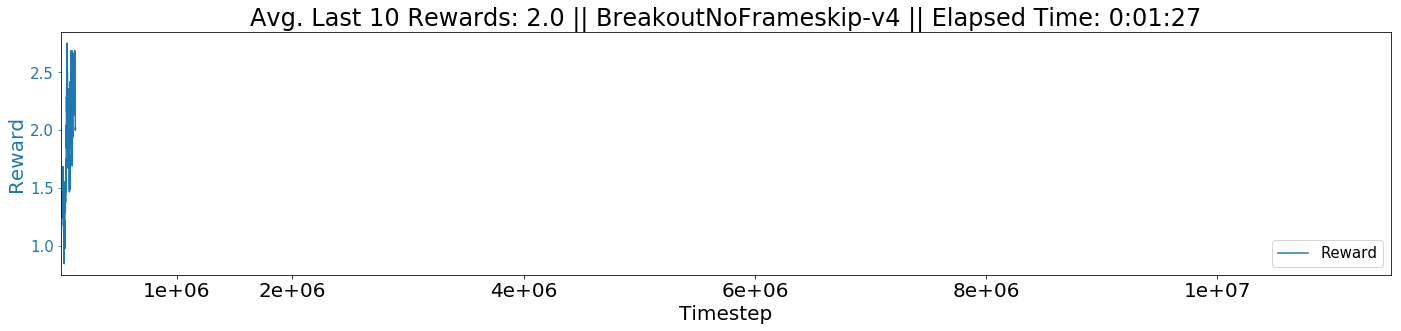

In [ ]:
from train import train 
%matplotlib inline

train(config, Agent, ipynb=True)